In [281]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image

In [282]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [283]:
#HyperParameters
imsize = 256
contentLayers = ['conv_4']
styleLayers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
steps = 300
styleWeight = 1e8
contentWeight = 0.75

In [284]:
def loadImage(image_name, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize),
        transforms.CenterCrop(imsize),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [285]:
style = loadImage("../data/style/wave.jpg", imsize)
content = loadImage("../data/content/nalport.jpg", imsize)

In [286]:
unloader = transforms.ToPILImage() #we need to transform it back from tensor to image

In [287]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [288]:
assert style.size() == content.size(), "we need to import style and content images of the same size"

In [289]:
plt.ion()

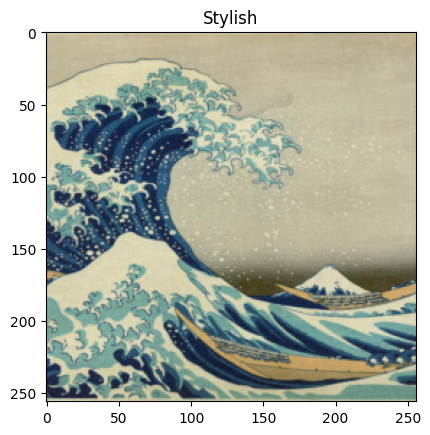

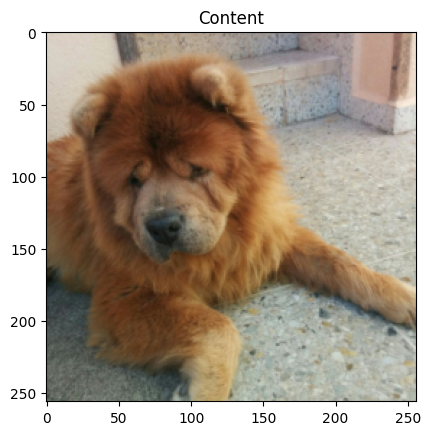

In [290]:
plt.figure()
imshow(style, title='Stylish')
plt.figure()
imshow(content, title='Content')


In [291]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target) #input being the current image at the time
        return input

In [292]:
def getGramMatrix(input):
    a,b,c,d = input.size()
    features = input.view(a*b, c*d) #inner product of the features 
    G = torch.mm(features, features.t())
    #normalize later
    return G.div(a*b*c*d)

In [293]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = getGramMatrix(target_feature).detach()
        self.loss = 0  # initialize loss attribute to 0
    def forward(self, input):
        G = getGramMatrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [294]:
# we might have to train our own
cnn = models.vgg19(pretrained = True).features.to(device).eval()

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [295]:
# Normalize network with special values for the mean and std

meanNormalization = torch.tensor([0.485,0.456, 0.406]).to(device)
stdNormalization = torch.tensor([0.229, 0.224, 0.225]).to(device)


In [296]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [297]:
def getStyleLoss(cnn, meanNormalization, stdNormalization, content, style,
                 contentLayers=contentLayers, styleLayers=styleLayers):
    
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(meanNormalization, stdNormalization).to(device)
    contentLosses = []
    styleLosses = []

    model = nn.Sequential(normalization)

    i = 0

    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'ReLu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            print('weird layer huh')
        
        model.add_module(name, layer)

        if(name in contentLayers):
            target = model(content).detach()
            contentLoss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), contentLoss)
            contentLosses.append(contentLoss)

        if name in styleLayers:
            target = model(style).detach()
            styleLoss = StyleLoss(target)
            model.add_module('style_loss_{}'.format(i), styleLoss)
            styleLosses.append(styleLoss)

    for i in range(len(model)):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break;

    model = model[:(i+1)]

    return model, styleLosses, contentLosses



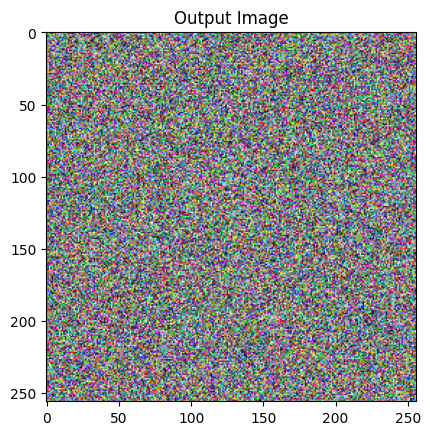

In [298]:
#inputImage = content.clone()
inputImage = torch.randn(content.data.size(), device=device)

plt.figure()
imshow(inputImage, title='Output Image')

In [299]:
def getOptimizer(inputImage):
    optimzer = optim.LBFGS([inputImage.requires_grad_()])
    return optimzer

In [300]:
def styleTransfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = getStyleLoss(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = getOptimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward(retain_graph=True)

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img


        

In [301]:
output = styleTransfer(cnn, meanNormalization, stdNormalization, content, style, inputImage, 
                       steps, styleWeight, contentWeight)

Building the style transfer model..


/tmp/ipykernel_1493/2441172473.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
/tmp/ipykernel_1493/2441172473.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1,1,1)


Optimizing..
run [50]:
Style Loss : 0.107783 Content Loss: 26.224943

run [100]:
Style Loss : 0.004956 Content Loss: 26.224943

run [150]:
Style Loss : 0.000931 Content Loss: 26.224943

run [200]:
Style Loss : 0.000316 Content Loss: 26.224943

run [250]:
Style Loss : 0.000145 Content Loss: 26.224943

run [300]:
Style Loss : 0.000089 Content Loss: 26.224943



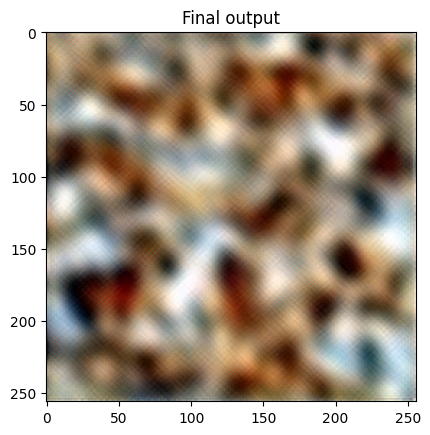

In [302]:
plt.figure()
imshow(output, title='Final output')
plt.ioff()
plt.show()